In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from ipywidgets import interactive, fixed

# Three Body Problem
## Lecture 19

## Review: Planetary Motion

Recall that we can simulate the motion of planet around the Sun with the followin equations of motion:

\begin{align}
\frac{d v_x}{dt} &= - \frac{G M}{r^3} x \\
\frac{d x}{dt} &= v_x \\
\frac{d v_y}{dt} &= - \frac{G M}{r^3} y \\
\frac{d y}{dt} &= v_y 
\end{align}


To solve this *dynamical system* we create a Python function that evalutes the functions on the right hand side of system.

In [2]:
def Fplanet(s, t, p):
    x, y, vx, vy = s
    
    GM, = p
    
    r = np.sqrt(x**2 + y**2)
    dsdt = [vx,
            vy,
            - GM/r**3 * x,
            - GM/r**3 * y,
            ]
        
    return np.array(dsdt)


We can solve this system with several different numerical methods, including a 4th order Runge-Kutta method:

In [3]:
def RK4Stepper( F = lambda s, t, p: s,  
                s0 = [0.1], t0 = 0, p = [],
                dt = 0.1,  tmax = 1):

    s = np.array(s0)
    t = t0

    while t < tmax:
        r = list(s)
        r.append(t)
        yield r
              
        ds1 = F(s, t, p)
        s1 = s + ds1*dt/2
        ds2 = F(s1, t + dt/2, p)
        s2 = s + ds2*dt/2
        ds3 = F(s2, t + dt/2, p)
        s3 = s + ds3*dt
        ds4 = F(s3, t + dt, p)
        s = s + (ds1 + 2*ds2 + 2*ds3 + ds4)/6*dt
        
        t = t + dt

In [4]:
def PlanetApp(x0=1, # AU
              y0 = 0,
              vx0 = 0,
              vy0 = 2*np.pi, # AU/yr
              tmax = 1, # one year
              dt = 0.01
              ):
        
    s0 =[x0, y0, vx0, vy0]
    
    ## GM in units of (AU)^3/(yr)^2
    GM = 4*np.pi**2 
    p = [GM] 
    
    stepper = RK4Stepper(Fplanet, s0=s0, dt=dt, tmax=tmax, p=p)
    data = pd.DataFrame(stepper, columns = ['x', 'y', 'vx', 'vy', 't'])    
    
    return data

In [5]:
data = PlanetApp()

data.head()

,x,y,vx,vy,t
0,1.000000,0.000000,0.000000,6.283185,0.00
1,0.998027,0.062791,-0.394525,6.270787,0.01
2,0.992115,0.125333,-0.787492,6.233641,0.02
3,0.982287,0.187381,-1.177352,6.171893,0.03
4,0.968583,0.248690,-1.562565,6.085787,0.04


We can visualize how a planet moves in its orbit using `interactive()`

In [6]:
def PlanetPlot(data, tmax=None):
       
    # plot data on up to tmax (if provided)
    if tmax is not None:
        data = data[data.t <= tmax]
    
    plt.plot(data.x, data.y, '-', linewidth=0.5)

    # Plot the Sun at the origin
    plt.plot(0, 0, '.',color="yellow", markersize=20, markeredgecolor='black')
    # Plot the Earth at the final position
    plt.plot(data.x.iloc[-1], data.y.iloc[-1], '.', color= 'k', markersize=15)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')


interactive( PlanetPlot,  data=fixed(data), tmax=(0, 1, 0.1))

interactive(children=(FloatSlider(value=0.0, description='tmax', max=1.0), Output()), _dom_classes=('widget-in…

In [7]:
data1 = PlanetApp(vy0=2*np.pi, tmax = 5)
data2 = PlanetApp(vy0=4, tmax = 5)
data3 = PlanetApp(vy0=2*np.pi+1, tmax = 5)
datas = [data1, data2, data3]
    
def ManyPlanetPlot(datas, tmax=None):
    for data in datas:
        PlanetPlot(data, tmax)
        
interactive(ManyPlanetPlot, datas=fixed(datas), tmax=(0, 5.0, 0.1))

interactive(children=(FloatSlider(value=2.5, description='tmax', max=5.0), Output()), _dom_classes=('widget-in…

## A Mini-Solar System

These initial examples for planetary orbits have been restricted to two-body central forces.  Of course the Solar System is not a two-body system: the planets exert gravitational forces on each other.

Although small compared to the gravitational force of the Sun, the net effect is measureable.  This is how the experimentally measured orbit of Uranus led to the conjecture about the existance of Neptune.

Recall: Le Verrier (1846) and the discovery of Neptune (e.g. Youtube Video https://www.youtube.com/watch?v=8Sm99OVG5A8 )

Since there are other forces involved, the total force on a particular planet is nolong er a central force. 

Strictly speaking, the orbits of the planets are not even all in the same plane but we will, for simplicity, assume only a two-dimensional solar system.

### Equations of Motion

$$\begin{align}
m_1 \frac{d^2 r_1}{dt^2} &= - \frac{GMm_1}{r_1^3}\vec{r_1} + \frac{Gm_1m_2}{r_{21}^3}\vec{r_{21}} \\
m_2 \frac{d^2 r_2}{dt^2} &= - \frac{GMm_2}{r_2^3}\vec{r_2} - \frac{Gm_1m_2}{r_{21}^3}\vec{r_{21}} \\
\end{align}
$$

where $\vec{r_1}$ and $\vec{r_2}$ are direction from the Sun to planets 1 and 2, respectively,  while $\vec{r_{21}} = \vec{r_2} - \vec{r_1}$ is the vector from planet 1 to planet 2.

We can divide the first equation by $m_1$ and the second equation by $m_2$ to get

$$\begin{align}
\frac{d^2 r_1}{dt^2} &= - \frac{GM}{r_1^3}\vec{r_1} + \frac{Gm_2}{r_{21}^3}\vec{r_{21}} \\
\frac{d^2 r_2}{dt^2} &= - \frac{GM}{r_2^3}\vec{r_2} - \frac{Gm_1}{r_{21}^3}\vec{r_{21}} \\
\end{align}
$$

To solve this system numerically, we need to write it as a system of first order differential equations for our variables:

$x_1, y_1, v_{x1}, v_{y1}, x_2, y_2, v_{x2}, v_{y2}$

The vectors $\vec{r_1}, \vec{r_2}, $ and $\vec{r_{21}}$ can be all written in terms of those variables.

Finally, $GM, m_1,$ and $m_2$ will be given as parameters. 



To implement this as numerical model, let's start by simulating two planets *without* a gravitational force between them. This is a simpler problem and will help sort out any programming issues.

In [8]:
def FTwoPlanets(s, t, p):
    x1, y1, vx1, vy1, x2, y2, vx2, vy2 = s
    
    GM, = p
    
    r1 = np.sqrt(x1**2 + y1**2)
    r2 = np.sqrt(x2**2 + y2**2)
    
    dsdt = [vx1,
            vy1,
            - GM/r1**3 * x1,
            - GM/r1**3 * y1,
            vx2,
            vy2,
            - GM/r2**3 * x2,
            - GM/r2**3 * y2,
            ]
        
    return np.array(dsdt)

In [10]:
def TwoPlanetApp(x10 = 1, # AU
                 y10 = 0,
                 vx10 = 0,
                 vy10 = np.sqrt(4*np.pi**2/1), # AU/yr
                 x20 = 2, # AU
                 y20 = 0,
                 vx20 = 0,
                 vy20 = np.sqrt(4*np.pi**2/2), # AU/yr
                 tmax = 8,
                 dt = 0.01
                ):
        
    s0 =[x10, y10, vx10, vy10, x20, y20, vx20, vy20]
    
    ## GM in units of (AU)^3/(yr)^2
    GM = 4*np.pi**2 
    p = [GM] 
    
    stepper = RK4Stepper(FTwoPlanets, s0=s0, dt=dt, tmax=tmax, p=p)
    data = pd.DataFrame(stepper, columns = ['x1', 'y1', 'vx1', 'vy1', 
                                            'x2', 'y2', 'vx2', 'vy2',
                                            't'])    
    
    return data

In the above two functions, we have doubled the number of variables and relabeled the variables as 1 and 2.

For *default* values, the first planet is a at a distance of 1 AU and the second is at 2 AU with initial velocities chosen so that the orbits will be circular, i.e. $ v= \left( \frac{GM}{r}\right)^{1/2}$

In [11]:
data = TwoPlanetApp()
data.head()

,x1,y1,vx1,vy1,x2,y2,vx2,vy2,t
0,1.000000,0.000000,0.000000,6.283185,2.000000,0.000000,0.000000,4.442883,0.00
1,0.998027,0.062791,-0.394525,6.270787,1.999507,0.044425,-0.098688,4.441787,0.01
2,0.992115,0.125333,-0.787492,6.233641,1.998026,0.088828,-0.197327,4.438499,0.02
3,0.982287,0.187381,-1.177352,6.171893,1.995560,0.133188,-0.295869,4.433020,0.03
4,0.968583,0.248690,-1.562565,6.085787,1.992110,0.177482,-0.394265,4.425355,0.04


In [12]:
def TwoPlanetPlot(data, tmax=None):
       
    # plot data on up to tmax (if provided)
    if tmax is not None:
        data = data[data.t <= tmax]
    
    plt.plot(data.x1, data.y1, '-', linewidth=0.5)
    plt.plot(data.x2, data.y2, '-', linewidth=0.5)

    # Plot the Sun at the origin
    plt.plot(0, 0, '.',color="yellow", markersize=20, markeredgecolor='black')
    
    # Plot the planet at the final position
    plt.plot(data.x1.iloc[-1], data.y1.iloc[-1], '.', color= 'k', markersize=15)
    plt.plot(data.x2.iloc[-1], data.y2.iloc[-1], '.', color= 'k', markersize=15)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')

interactive( TwoPlanetPlot,  data=fixed(data), tmax=(0, 8, 0.1))

interactive(children=(FloatSlider(value=4.0, description='tmax', max=8.0), Output()), _dom_classes=('widget-in…

Once we have the application working with two planets, we can add the new force:

In [15]:
def FTwoPlanets(s, t, p):
    
    x1, y1, vx1, vy1, x2, y2, vx2, vy2 = s
    
    GM, m1, m2 = p
    
    r1 = np.sqrt(x1**2 + y1**2)
    r2 = np.sqrt(x2**2 + y2**2)
    
    dx = (x2 - x1)
    dy = (y2 - y1)
    dr = np.sqrt(dx**2 + dy**2)
    
    dsdt = [vx1,
            vy1,
            - GM/r1**3 * x1 + GM*m2/dr**3 * dx,
            - GM/r1**3 * y1 + GM*m2/dr**3 * dy,
            vx2,
            vy2,
            - GM/r2**3 * x2 - GM*m1/dr**3 * dx,
            - GM/r2**3 * y2 - GM*m1/dr**3 * dy,
            ]
        
    return np.array(dsdt)

We need to also now consider the mass of the planets as parameters (in additional to `GM`).  Rather than kilograms, we can use the mass of the Sun, $M$, as the standard unit of mass.  For example, the two planets might be

$$\frac{m_1}{M} = 0.001$$

and

$$\frac{m_2}{M} = 0.04$$

That is, the first planet is 1/1000 of the mass of the Sun while the second planet is 4/100 of the mass of the Sun.

This means that 

$$G m_2 = \left(\frac{m_2}{M}\right) GM = 0.001 GM$$

and

$$G m_1 = \left(\frac{m_2}{M}\right) GM = 0.04 GM$$


We can pass as these masses as additional parameters.


In [16]:
def TwoPlanetApp(x10 = 1, # AU
                 y10 = 0,
                 vx10 = 0,
                 vy10 = np.sqrt(4*np.pi**2/1), # AU/yr
                 m1 = 0.001, # in solar mass units
                 x20 = 2, # AU
                 y20 = 0,
                 vx20 = 0,
                 vy20 = np.sqrt(4*np.pi**2/2), # AU/yr
                 m2 = 0.04,
                 tmax = 8,
                 dt = 0.01
                ):
        
    s0 =[x10, y10, vx10, vy10, x20, y20, vx20, vy20]
    
    ## GM in units of (AU)^3/(yr)^2
    GM = 4*np.pi**2 
    p = [GM, m1, m2] 
    
    stepper = RK4Stepper(FTwoPlanets, s0=s0, dt=dt, tmax=tmax, p=p)
    data = pd.DataFrame(stepper, columns = ['x1', 'y1', 'vx1', 'vy1', 
                                            'x2', 'y2', 'vx2', 'vy2',
                                            't'])    
    
    return data

The plotting function requires no other changes.

In [17]:
data = TwoPlanetApp()

interactive(TwoPlanetPlot,  data=fixed(data), tmax=(0, 8, 0.1))

interactive(children=(FloatSlider(value=4.0, description='tmax', max=8.0), Output()), _dom_classes=('widget-in…

It appears that the orbit of the inner planet is being perturbed by the more massive (40 times as massive) outer planet.

### Real planets

Of course, 'real planets' are not nearly so massive nor so near each other.

Jupiter, the largest planet itself is only $955 \times 10^{-6}$ of the mass of the Sun while being about 5.2 AU away from the Sun. 

Mercury, at $0.166 \times 10^{-6}$ solar masses, is the closet planet to the Sun at a distance of 0.39 AU. 

Its effect of Jupiter on the orbit of Mercury is not nearly as dramatic as what was being shown in the first example but it is real and measurable.

#### Eccentricity

Real planets also have slight eccentric orbits. If $a$ is the semi-major axis and $b$ is the semi-minor axis, then

$$ e = \sqrt{1 - \frac{b^2}{a^2} } $$

called the eccentricity, $e$, is a measure of how circular or not an ellipse really is. For circle $a=b$ so $e = 0$ but for general ellipse $0<e<1$.  

For general orbits, the speed is not a constant.  We can relate velocity to position using the *vis-viva* equation. ( See [Vis Viva equation](https://en.wikipedia.org/wiki/Vis-viva_equation) for a derivation based on conservation of energy and momentum)

$$  v = \sqrt{ GM \left( \frac{2}{r} - \frac{1}{a} \right) } $$

We can relate the velocity at the nearest point to the Sun to the eccentricity of the orbit:

![Kepler's Law](http://hyperphysics.phy-astr.gsu.edu/hbase/imgmec/kep.gif)

The orbital parameters of the planets are often reported in terms of their semi-major axis $a$ and their eccentricity $e$.

| Planet  | Mass | a | e |
| ------- | -- | -- | -- |
| Mercury | 1.66e-7 | 0.39, | 0.207 |
| Earth   | 3.00e-6 | 1.00 | 0.017|  
| Jupiter | 9.55e-4 | 5.20 | 0.048|


Assuming a planet starts at its perihelion

$$x_0 = R_a = a(1-e) $$

we can calculate the needed initial velocity to maintain a given eccentricity:

$$  v_{y0} = \sqrt{ \frac{GM}{a} \left( \frac{1+e}{1-e} \right) } $$

In [18]:
def JupiterMercuryApp(m1 = 1.66e-7, m2 = 9.54e-4):

    a1 = 0.39
    e1 = 0.207
    x1 = a1*(1-e1)
    vy1 = np.sqrt(4*np.pi**2/a1 * (1+e1)/(1-e1))

    a2 = 5.20
    e2 = 0.048
    x2 = a2*(1-e2)
    vy2 = np.sqrt(4*np.pi**2/a2 * (1+e2)/(1-e2))

    data = TwoPlanetApp(x10 = x1, vy10=vy1, m1 = m1, 
                        x20 = x2, vy20=vy2, m2 = m2,
                        tmax = 1, dt=0.001)

    return data

data = JupiterMercuryApp()
interactive(TwoPlanetPlot,  data=fixed(data), tmax=(0, 1, 0.05))

interactive(children=(FloatSlider(value=0.0, description='tmax', max=1.0, step=0.05), Output()), _dom_classes=…

On this scale, it is very difficult to see what is happening to Mercury. We already have a plotting tool that that works for one planet; we just need to change some variable names to continue to use it.

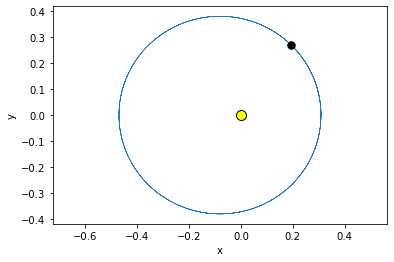

In [19]:
data['x'] = data['x1']
data['y'] = data['y1']

PlanetPlot(data)

Still difficult to see if anything is really changing.

On technique is use a much bigger forcing.  What if Jupiter was 200 times more massive? 

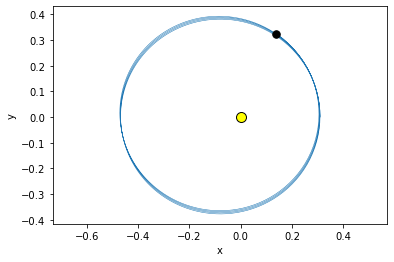

In [20]:
data = JupiterMercuryApp(m2 = 9.54e-4 * 200)

data['x'] = data['x1']
data['y'] = data['y1']
PlanetPlot(data)

Something appears to be happening to orbit of Mercury.  Let's look at the distance from Mercury to the Sun.

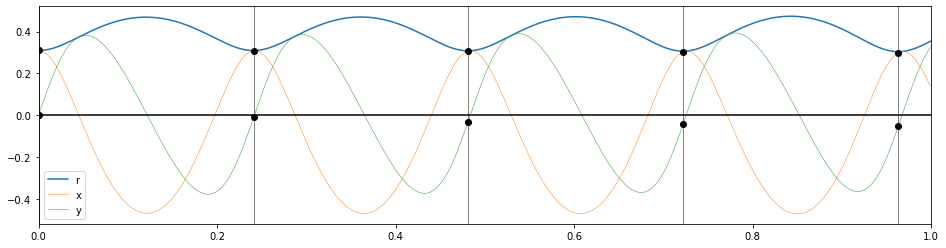

In [24]:
data['r'] = np.sqrt(data.x**2 + data.y**2)

fig = plt.figure(figsize=(16,4))

plt.plot(data.t, data.r, '-', label='r')
plt.plot(data.t, data.x, '-', linewidth=0.5, label='x')
plt.plot(data.t, data.y, '-', linewidth=0.5, label='y')

plt.axvline(data.t[0], color='k', linewidth=0.5)
plt.plot(data.t[0], data.x[0], 'ko')
plt.plot(data.t[0], data.y[0], 'ko')
perihelions = [ {'t': data.t[0], 'x': data.x[0], 'y': data.y[0]}]

N = len(data)
for i in range(1, N-1):
    if (data.r[i-1] >= data.r[i]) and (data.r[i] <= data.r[i+1]):
        plt.axvline(data.t[i], color='k', linewidth=0.5)
        plt.plot(data.t[i], data.x[i], 'ko')
        plt.plot(data.t[i], data.y[i], 'ko')
        perihelions.append( {'t': data.t[i], 'x': data.x[i], 'y': data.y[i]} )

plt.axhline(0, color='k')
plt.xlim(0, 1)
plt.legend()

Here we look for when the perihelion, the closest point between the planet and the Sun, occurs. Notice that the simluation starts off with the perihelion at $x=x_0$ and $y = 0$. 

But over time, the location of the perihelion is moving clockwise.  We say that the perihelion is precessing.

In [25]:
perihelion = pd.DataFrame(perihelions)
perihelion['θ'] = np.arctan2(perihelion.y, perihelion.x)

In [26]:
perihelion

,t,x,y,θ
0,0.000,0.309270,0.000000,0.000000
1,0.241,0.308766,-0.009180,-0.029721
2,0.481,0.306207,-0.031051,-0.101060
3,0.722,0.303208,-0.041061,-0.134603
4,0.963,0.299103,-0.051862,-0.171683


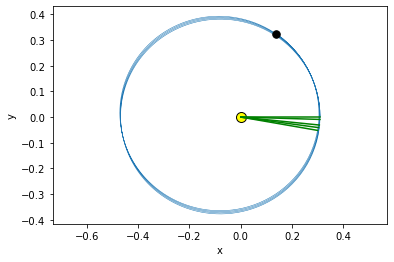

In [27]:
PlanetPlot(data)
for i, row in perihelion.iterrows():
    plt.plot([0, row['x']], [0, row['y']], 'g-')

dθdt = -0.1862 rad/yr


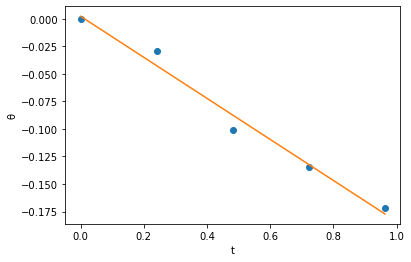

In [28]:
plt.plot(perihelion.t, perihelion.θ, 'o')
plt.xlabel('t')
plt.ylabel('θ')

p = np.polyfit(perihelion.t, perihelion.θ, 1)
plt.plot(perihelion.t, np.polyval(p, perihelion.t))

dθdt = p[0]

print(f'dθdt = {dθdt:.4f} rad/yr')

We can complete this entire analysis, omitting the plots, as a function the scaling factor $S$ on Jupiter.

In [29]:
def EstimatePrecessionRate(S=200):
    
    data = JupiterMercuryApp(m2 = 9.54e-4 * S)

    data['x'] = data['x1']
    data['y'] = data['y1']
    
    data['r'] = np.sqrt(data.x**2 + data.y**2)

    perihelions = [ {'t': data.t[0], 'x': data.x[0], 'y': data.y[0]}]

    N = len(data)
    for i in range(1, N-1):
        if (data.r[i-1] >= data.r[i]) and (data.r[i] <= data.r[i+1]):
            perihelions.append( {'t': data.t[i], 'x': data.x[i], 'y': data.y[i]} )
    perihelion = pd.DataFrame(perihelions)
    perihelion['θ'] = np.arctan2(perihelion.y, perihelion.x)

    p = np.polyfit(perihelion.t, perihelion.θ, 1)

    dθdt = p[0]
    
    return dθdt

In [30]:
dθdt = EstimatePrecessionRate(200)
print(f'dθdt = {dθdt:.4f} rad/yr')

dθdt = -0.1862 rad/yr


This shows that our analysis function still give the same answer.

Ideally, we would just calculate `EstimatePrecessionRate(1)`


In [31]:
dθdt = EstimatePrecessionRate(1)
print(f'dθdt = {dθdt:.4f} rad/yr')

dθdt = -0.0076 rad/yr


However, if you go back and look at the plots associated with this analysis (which you are welcome to do) you may not be convinced of the precession.

Instead we can then calculate the precession rate for a range of scaling factors

In [32]:
results = []
for S in tqdm.tqdm_notebook(range(0, 200, 20)):
    dθdt = EstimatePrecessionRate(S)
    results.append({'S': S, 'dθdt': dθdt})
results = pd.DataFrame(results)

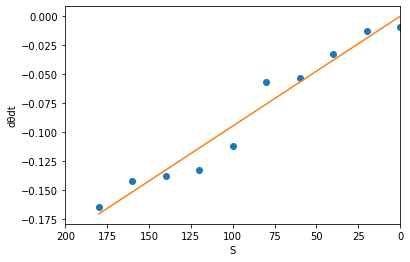

In [33]:
plt.plot(results.S, results.dθdt, 'o')
plt.xlabel('S')
plt.ylabel('dθdt')

p = np.polyfit(results.S, results.dθdt, 1)
plt.plot(results.S, np.polyval(p, results.S))
plt.xlim(200, 0)
plt.show()

Notice that notwithstanding the variation in the precession rate, there is an approximate linear trend as the scaling factor of Jupiter get smaller.  To determine the precession rate for Mercurcy, we can use this linear regression line.

In [34]:
dθdt = np.polyval(p, 1)
print(f'dθdt = {dθdt:.4f} rad/yr')

dθdt = -0.0011 rad/yr


- - -
### Textbook readings

This lecture is based on CSM Chapter 5:

- 5.6 Simulation of the Orbit
- 5.9  A Mini-Solar System